<a href="https://colab.research.google.com/github/okagen/study/blob/master/studyGoogleColaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting with Prophet
Prophetを用いて、時系列予測を行う

## Step 0 : Preparation.

### Upgrade statsmodels. (Execute once.)
statsmodelsをアップデートしておく。

In [0]:
## Execute below once.
# pip install --upgrade git+https://github.com/statsmodels/statsmodels

### Uplaod the AirPassengers data which was downloaded from Kaggole into Google Coloaboratory. (Execute once.)
KaggoleからAirPassengers.csvをダウンロードし、Google Colaboratoryにアップロードする。

  - The AirPassengers.csv is going to be stored in content directory. / AirPassengers.csvはcontentディレクトリの下に保存される。
  

In [0]:
## Execute below once.
#from google.colab import files
#uploaded = files.upload()

## Step 1 : Import data.

### Import libraries.

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings

# Ignore wornings.
warnings.filterwarnings("ignore")

### Import the AirPassengers data which was uploaded into the Google Colaboratory as Pandas DataFrame. 
Pandas DataFrameの形式で、AirPassengers.csvを読み込む。

  - Set "Month" column as datetime index. / Month列を、時系列データのIndexにする。
  - Set "Passengers" column as float. / Passengers列をを浮動小数点にする。

In [0]:
df = pd.read_csv('AirPassengers.csv', 
                 parse_dates = ["Month"],
                 index_col= ["Month"],
                 dtype = {'#Passengers' : 'float'})

### Show the head and tail of the DataFrame.

In [76]:
display(df.head(5))
display(df.tail(5))
print("---------------------")
df.describe()

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


,#Passengers
Month,
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0
1960-11-01,390.0
1960-12-01,432.0


---------------------


,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


### Show the data on a line chart. 
折れ線チャートで表示してみる
  - The chart has a period. / チャートには周期がある。
    - The number of passenger depends on season. / Passenger数は季節に依存する。 
    - It's high in summer and low in winter. / Passenger数は、夏多くて、冬少ない。
  - The chart has upward trend. / チャートは上昇トレンド傾向にある。

Text(0, 0.5, 'Passengers')

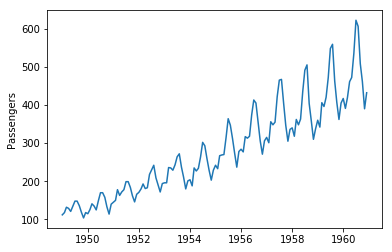

In [77]:
plt.plot(df["#Passengers"])
plt.ylabel("Passengers")

## Step 2 :  Predict by using Prophet.
Prophetを使って予測する。

In [0]:
from fbprophet import Prophet

### Use the data from 1949-01-01 to 1958-12-31 as the train data. 
Slice data from 1949-01-01 to 1958-12-31 of the DataFrame then re-form it as a train data. / DataFrameから1949.1.1～1958.12.31のデータをスライスし、トレーニングデータとして整形する。

In [79]:
# slice the DataFrame.
train = df[:"1958-12-31"]
display(train.head(5))
# re-form it as a train data.
train = train.reset_index().rename(columns={'Month' : 'ds', '#Passengers' : 'y'})
display(train.head(5))

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


### Create a model object.
モデルオブジェクト生成
  - Use 'linear' into trend models non-periodic changes. / トレンドモデルの非周期的な変化を、線形に設定。
  - It seems to be annual cycle so considering only the annual cycle. / 年間周期のみを考慮。
  - Use 'multiplicative' as mode because it seems the regressor will multiply the trend rather then the effect of the regressor will be added to the trend. / 「トレンド＋周期成分」よりも「トレンドｘ周期成分」の構造が予想される為、'multiplicative'をmodeに設定する。
  - Default value is 0.05 for changepoint_prior_scale. / changepoint_prior_scaleのデフォルト値は0.05.


In [0]:
m = Prophet(growth = "linear",
           yearly_seasonality = 10,
           weekly_seasonality = False,
           daily_seasonality = False,
           seasonality_mode = 'multiplicative',
           changepoint_prior_scale=0.1).fit(train)

### Specify the forecast period and create a DataFrame to store the forecast value.
予測期間を指定し、予測値を保存するためのデータフレームを作成する。

  - Monthly data is stored in AirPassengers.csv, which is data for the first day of each month. That's why I set frep='MS’ to create DataFrame for predict data. It's going to create only for the first day each month. / AirPassengers.csvには月次データが保存されており、各月1日のデータとなっている。よってfrep='MS’’を設定し、予測用の毎月1日のDataFrameを生成する。

In [81]:
future = m.make_future_dataframe(periods = 48, freq='MS')

display(future.head(5))
display(future.tail(5))

,ds
0,1949-01-01
1,1949-02-01
2,1949-03-01
3,1949-04-01
4,1949-05-01


,ds
163,1962-08-01
164,1962-09-01
165,1962-10-01
166,1962-11-01
167,1962-12-01


### Predict by using predict(). then plot.
  - The black dots which indicate the data points used to train the model. / 黒いドットはトレーニングに使った観測点。
  - The blue line plots the prediction. / 青い線は、予測。
  - The light blue belt is a confidence interval. 80%. / 薄い青色の帯は、信頼区間80%。

In [0]:
forecast = m.predict(df =  future)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1949-01-01,120.742737,97.656910,119.254970,120.742737,120.742737,-0.100400,-0.100400,-0.100400,-0.100400,-0.100400,-0.100400,0.0,0.0,0.0,108.620166
1,1949-02-01,121.835300,93.774977,115.671506,121.835300,121.835300,-0.144280,-0.144280,-0.144280,-0.144280,-0.144280,-0.144280,0.0,0.0,0.0,104.256849
2,1949-03-01,122.822132,112.991176,134.290070,122.822132,122.822132,0.003830,0.003830,0.003830,0.003830,0.003830,0.003830,0.0,0.0,0.0,123.292504
3,1949-04-01,123.914696,109.299676,130.563448,123.914696,123.914696,-0.031318,-0.031318,-0.031318,-0.031318,-0.031318,-0.031318,0.0,0.0,0.0,120.033960
4,1949-05-01,124.972016,110.641112,132.393955,124.972016,124.972016,-0.027509,-0.027509,-0.027509,-0.027509,-0.027509,-0.027509,0.0,0.0,0.0,121.534165


-------


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
163,1962-08-01,491.338121,561.757065,647.198629,457.336798,525.200515,0.230645,0.230645,0.230645,0.230645,0.230645,0.230645,0.0,0.0,0.0,604.662991
164,1962-09-01,493.448125,479.703450,556.928993,458.638793,528.631757,0.051678,0.051678,0.051678,0.051678,0.051678,0.051678,0.0,0.0,0.0,518.948438
165,1962-10-01,495.490064,419.637288,488.775696,459.891261,531.988095,-0.086014,-0.086014,-0.086014,-0.086014,-0.086014,-0.086014,0.0,0.0,0.0,452.870945
166,1962-11-01,497.600068,360.709473,423.668626,460.058848,535.372364,-0.211670,-0.211670,-0.211670,-0.211670,-0.211670,-0.211670,0.0,0.0,0.0,392.273137
167,1962-12-01,499.642007,403.978941,475.509774,461.418320,538.468032,-0.119683,-0.119683,-0.119683,-0.119683,-0.119683,-0.119683,0.0,0.0,0.0,439.843111


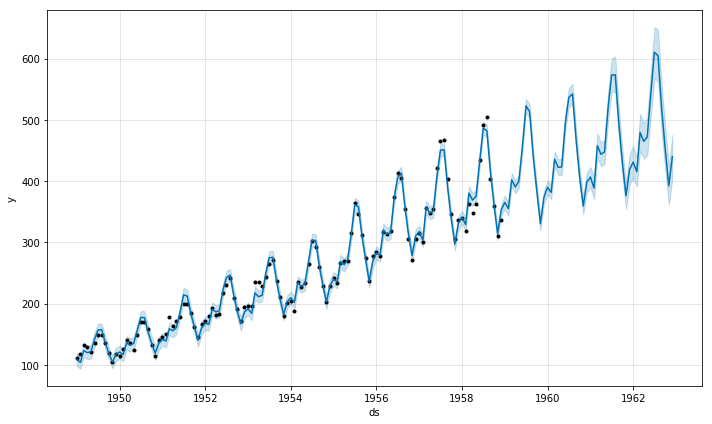

In [83]:
display(forecast.head(5))
print("-------")
display(forecast.tail(5))
fig = m.plot(forecast)

## Step 3 : Analyse

### Show significant changepoints of trend on prophet forecast plot.
トレンドの変化点をプロットする。

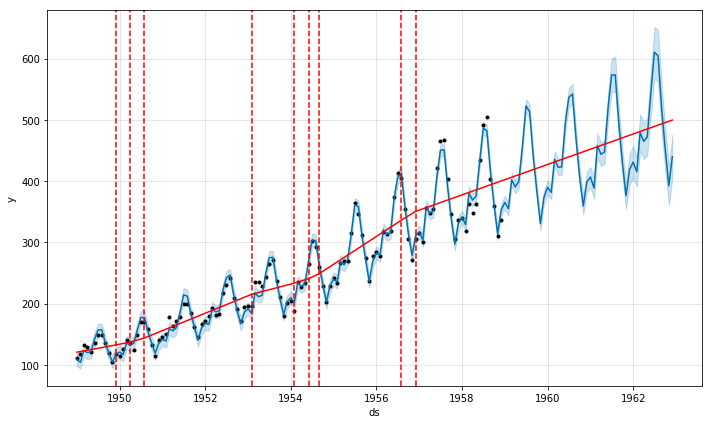

In [85]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

### Show trend transision and yearly cycle.
トレンドの推移と、年周期を表示

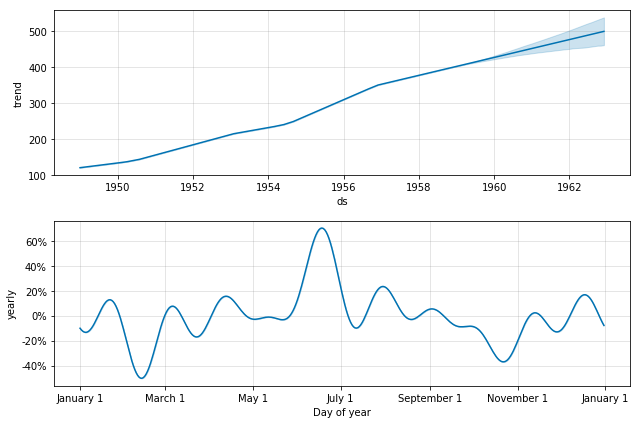

In [84]:
fig = m.plot_components(forecast)

### Compare the predict data with the actual data.
予測データと実績データとの比較。
  - Show the actual data on a scatter chart. / 実際の観測点を散布図に表示。

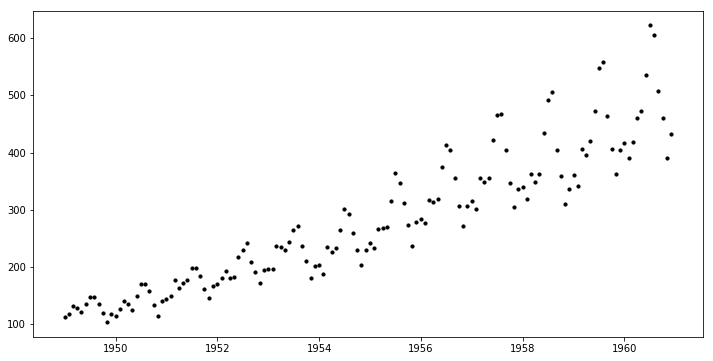

In [86]:
plt.figure(figsize=(12,6))
plt.scatter(df.index, df["#Passengers"], color = "black", s = 10)

  - Plot predict data on the scatter chart of the actual data. / 実績の散布図時に予測データを重ねる。

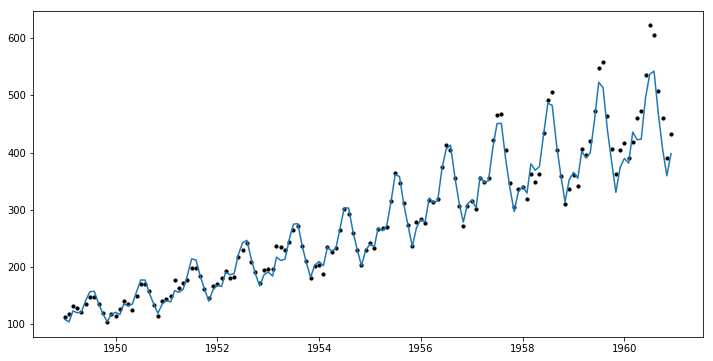

In [87]:
plt.figure(figsize=(12,6))
plt.scatter(df.index, df["#Passengers"], color = "black", s = 10)
plt.plot(forecast["ds"][:144], forecast["yhat"][:144])

  - Plot confidence interval on the chart above. / 上のチャートに信頼区間をプロット。

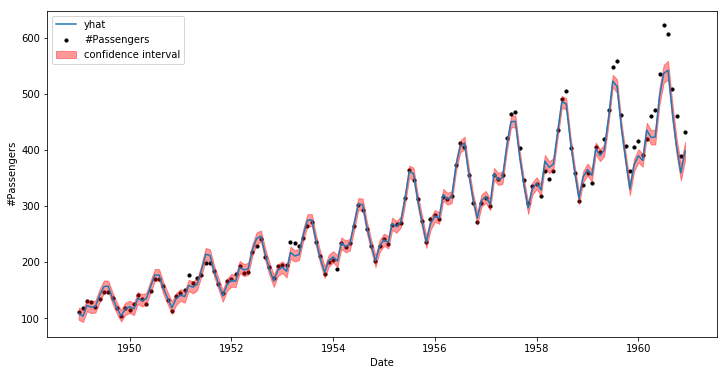

In [88]:
plt.figure(figsize=(12,6))
plt.scatter(df.index, df["#Passengers"], color = "black", s = 10)
plt.plot(forecast["ds"][:144], forecast["yhat"][:144])

plt.fill_between(df.index, 
                 forecast["yhat_upper"][:144],
                 forecast["yhat_lower"][:144],
                 color="red", alpha = .4, label ="confidence interval"
                )

plt.xlabel("Date")
plt.ylabel("#Passengers")
plt.legend()